In [1]:
import copy
from datetime import datetime
from joblib import Parallel, delayed
import lightgbm as lgb
from lightgbm.callback import early_stopping, log_evaluation
import numpy as np
import pandas as pd
import random
from scipy.signal import resample
from sdtw import SoftDTW
from sdtw.distance import SquaredEuclidean

In [2]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = [18, 6]

In [3]:
from truth import IeeeGroundTruth
from wavelet import apply_wavelet
from peaks import get_peaks_v2
from signal_pross import (
    normalize_signal,
    detrend_w_poly,
    normalize_amplitude_to_1,
    n_moving_avg,
    min_max_scale,
    bandpass,
    get_hr
)

In [4]:
truths = []
for subject in range(1, 8):

    truth = IeeeGroundTruth(subject, 1, directory = 'channel_data3')
    truth.align_rgb_bvp()
    truth.fill_nans()
    truth.process_rgb()
    truth.process_bvp()

    truths.append(truth)

In [5]:
class LossFactory:

    def __init__(self, split_size, loss_type = 'mse', gamma = 1.0, mse_weight = None, dtw_weight = None):
        
        if loss_type not in ['mse', 'dtw', 'combined']:
            raise ValueError(f'Loss type [{loss_type}] not supported')
        
        self.split_size = split_size
        self.gamma = gamma
        self.mse_weight = mse_weight
        self.dtw_weight = dtw_weight

        if loss_type == 'mse':
            self.loss_function = self.mse_loss
        elif loss_type == 'dtw':
            self.loss_function = self.soft_dtw_loss
        elif loss_type == 'combined':
            self.loss_function = self.combined_loss
        
    def __call__(self, y_pred, data):
        return self.loss_function(y_pred, data)

    def mse_loss(self, y_pred, data):
        
        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        errs = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            err = y_true_curr - y_pred_curr
            errs[i * self.split_size: (i + 1) * self.split_size] = err

        grad = -2 * errs
        hess = 2 * np.ones_like(y_true)
        return grad, hess

    def soft_dtw_loss(self, y_pred, data):

        y_true = data.get_label()
        num_batches = int(len(y_pred) / self.split_size)
        grads = np.zeros_like(y_true)
        hesses = np.zeros_like(y_true)

        for i in range(num_batches):

            y_true_curr = y_true[i * self.split_size: (i + 1) * self.split_size]
            y_pred_curr = y_pred[i * self.split_size: (i + 1) * self.split_size]
            
            grad_curr, hess_curr = self.soft_dtw_loss_helper(y_true_curr, y_pred_curr)
            grad_curr = grad_curr.flatten()
            hess_curr = hess_curr.flatten()

            grads[i * self.split_size: (i + 1) * self.split_size] = grad_curr
            hesses[i * self.split_size: (i + 1) * self.split_size] = hess_curr

        return grads, hesses
    
    def soft_dtw_loss_helper(self, y_true, y_pred):
        x = y_true.reshape(-1, 1)
        y = y_pred.reshape(-1, 1)
        D = SquaredEuclidean(x, y)
        sdtw = SoftDTW(D, gamma = self.gamma)
        sdtw.compute()
        E = sdtw.grad()
        G = D.jacobian_product(E)
        return G, np.ones(len(G))
    
    def combined_loss(self, y_pred, data):

        if self.mse_weight is None or self.dtw_weight is None:
            raise ValueError('mse_weight and dtw_weight must be set before calling combined_loss')

        mse_grads, mse_hesses = self.mse_loss(y_pred, data)
        dtw_grads, dtw_hesses = self.soft_dtw_loss(y_pred, data)

        combined_grad = self.mse_weight * mse_grads + self.dtw_weight * dtw_grads
        combined_hess = self.mse_weight * mse_hesses + self.dtw_weight * dtw_hesses

        return combined_grad, combined_hess

In [41]:
class LonePineGBM:
    
    def __init__(self, truths, label_col = 'bvp', subject_col = 'subject',
                # model customization
                model_type = 'gbdt', random_state = None, loss_type = 'mse', excluded_subject = None,
                # hyperparameters
                n_estimators = 100, split_size = 1280, learning_rate = 0.1, test_size = 0.3, early_stopping_rounds = 50,
                mse_weight = None, dtw_weight = None, data_beg = 1000, data_end = 10000, batches = 1, finetune = False):
        
        if model_type not in ['gbdt', 'rf']:
            raise ValueError(f'Model type [{model_type}] not supported')
        
        self.label_col = label_col
        self.subject_col = subject_col

        self.model_type = model_type
        self.random_state = random_state
        self.excluded_subject = excluded_subject

        self.n_estimators = n_estimators
        self.split_size = split_size
        self.learning_rate = learning_rate
        self.test_size = test_size
        self.early_stopping_rounds = early_stopping_rounds

        self.data_beg = data_beg
        self.data_end = data_end
        self.finetune = finetune

        self.gbm = None
        self.training_loss = None
        self.test_loss = None

        self.given_data = self.prepare_dataset_from_subjects(truths, data_beg = data_beg, data_end = data_end)
        self.features = list(self.given_data.drop(columns = [self.label_col, self.subject_col]).columns)
        if self.excluded_subject is not None:
            self.given_data = self.given_data[self.given_data[self.subject_col] != self.excluded_subject]

        if self.random_state is not None:
            random.seed(self.random_state)
        splits = self.split_data()
        self.train_split_indices = random.sample(range(len(splits)), int(len(splits) * (1 - self.test_size)))
        self.train_splits = [splits[i] for i in self.train_split_indices]
        self.test_splits = [splits[i] for i in range(len(splits)) if i not in self.train_split_indices]
        
        self.train_data = []
        batch_size = len(self.train_splits) // batches
        print(f'Rows per batch: {batch_size * self.split_size}')
        for batch_num in range(batches):
            batch_split_idxs = random.sample(range(len(self.train_splits)), batch_size)
            batch_splits = [self.train_splits[i] for i in batch_split_idxs]
            self.train_splits = [self.train_splits[i] for i in range(len(self.train_splits)) if i not in batch_split_idxs]

            train_indices = [idx for split in batch_splits for idx in split]
            training_rows = self.given_data.iloc[train_indices].drop(columns = [self.subject_col])
            train_X = training_rows.drop(columns = [self.label_col]).to_numpy()
            train_y = training_rows[self.label_col].to_numpy()

            batch_data = lgb.Dataset(train_X, train_y, free_raw_data = False)
            self.train_data.append(batch_data)

        test_indices = [idx for split in self.test_splits for idx in split]
        test_rows = self.given_data.iloc[test_indices].drop(columns = [self.subject_col])
        test_X = test_rows.drop(columns = [self.label_col]).to_numpy()
        test_y = test_rows[self.label_col].to_numpy()
        self.test_data = lgb.Dataset(test_X, test_y, free_raw_data = False)

        self.loss = LossFactory(self.split_size, loss_type = loss_type, mse_weight = mse_weight, dtw_weight = dtw_weight)
    
    def split_data(self, to_exclude = None):
        
        data_in_use = self.given_data if to_exclude is None else self.given_data[~self.given_data[self.subject_col].isin(to_exclude)]

        subject_indices = data_in_use.groupby(self.subject_col).indices
        splits = []
        for _, indices in subject_indices.items():
            
            n_splits = len(indices) // self.split_size
            if n_splits > 0:

                subject_splits = []
                for i in range(n_splits):
                    split_start = i * self.split_size
                    split_end = (i + 1) * self.split_size
                    subject_split = indices[split_start: split_end]
                    subject_splits.append(subject_split)
                
                splits.extend(subject_splits)
        
        return splits

    def fit(self):
        t1 = datetime.today()
        
        params = {
            'metric': 'None',
            'verbosity': -1,
            'learning_rate': self.learning_rate,
            'objective': 'regression',
            'boosting': self.model_type,
        }
    
        if self.model_type == 'rf':
            params['bagging_freq'] = 1
            params['bagging_fraction'] = 0.8


        training_loss_key = 'hr_err'
        feval = self.hr_error_eval_metric
        
        training_meta = {}

        for train_data in self.train_data:
            
            if self.model_type == 'gbdt':
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = self.gbm
                )
            else:
                self.gbm = lgb.train(
                    params,
                    train_data,
                    valid_sets = [train_data, self.test_data],
                    valid_names=['train', 'test'],
                    num_boost_round = self.n_estimators,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                )

            mse, hr_err, hr_err_sq = self.eval()
            print(f'Before fine-tuning: MSE = {mse}, HR error = {hr_err}, HR error (squared) = {hr_err_sq}')

            if self.model_type == 'gbdt' and self.finetune:
                
                print('\n\nFine-tuning...')
                gbm_copy = copy.deepcopy(self.gbm)
                pred = gbm_copy.predict(train_data.get_data())
                
                # new_targ = train_data.get_label() - pred
                new_targ = np.ones(len(pred))
                nsplits = len(pred) // self.split_size
                labels = train_data.get_label()
                for i in range(nsplits):
                    pred_curr = pred[i * self.split_size: (i + 1) * self.split_size]
                    label_curr = labels[i * self.split_size: (i + 1) * self.split_size]
                    hr_err = self.get_hr_error(pred_curr, label_curr, square = True)
                    new_targ[i * self.split_size: (i + 1) * self.split_size] = hr_err
                
                new_train_data = lgb.Dataset(train_data.get_data(), label = new_targ)

                self.gbm = lgb.train(
                    params,
                    new_train_data,
                    valid_sets = [new_train_data, self.test_data],
                    valid_names=['train', 'test'],
                    fobj = self.loss,
                    num_boost_round = self.n_estimators // 2,
                    feval=feval,
                    callbacks=[
                        early_stopping(stopping_rounds = self.early_stopping_rounds // 2),
                        log_evaluation(period=5)
                    ],
                    evals_result = training_meta,
                    init_model = gbm_copy
                )

            

        self.training_loss = training_meta['train'][training_loss_key]
        self.test_loss = training_meta['test'][training_loss_key]
        print(f'Finished training in {datetime.today() - t1}')

    def predict(self, X):
        return self.gbm.predict(X)

    def eval(self):
        
        test_X = self.test_data.get_data()
        test_y = self.test_data.get_label()
        nsplits = int(len(test_X) / self.split_size)
        errs = []
        mses = np.zeros(len(test_X))
        
        for i in range(nsplits):

            curr_pred = self.predict(test_X[i * self.split_size: (i + 1) * self.split_size, :])
            curr_true = test_y[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 5, use_bandpass = True)
            
            mses[i * self.split_size: (i + 1) * self.split_size] = curr_true - curr_pred
            hr_err = self.get_hr_error(curr_true, curr_pred, square = False)
            errs.append(hr_err)
        
        return np.mean(np.square(mses)), np.mean(errs), np.mean(np.square(errs))

    def plot_loss(self):
        if self.training_loss is not None and self.test_loss is not None:
            training_loss_normed = min_max_scale(self.training_loss)
            test_loss_normed = min_max_scale(self.test_loss)
            plt.plot(training_loss_normed, label = 'training loss')
            plt.plot(test_loss_normed, label = 'test loss')
            plt.legend()
        
    def get_model_stats(self):

        model_info = self.gbm.dump_model()
        tree_depths = []

        for tree_info in model_info['tree_info']:
            tree_structure = tree_info['tree_structure']
            
            # Recursive function to compute the depth of a tree
            def calculate_depth(node, current_depth=0):
                if 'leaf_value' in node:
                    return current_depth
                else:
                    left_depth = calculate_depth(node['left_child'], current_depth + 1)
                    right_depth = calculate_depth(node['right_child'], current_depth + 1)
                    return max(left_depth, right_depth)

            tree_depth = calculate_depth(tree_structure)
            tree_depths.append(tree_depth)
        

        print(f'Best test loss: {min(self.test_loss)}\n')
        print('Tree depth stats:')
        print('Min tree depth:', min(tree_depths))
        print('Max tree depth:', max(tree_depths))
        print('Avg tree depth:', np.mean(tree_depths))
        print('\nFeature importances:')
        display(self.get_feature_importances())
    
    def get_feature_importances(self):
        importances = self.gbm.feature_importance(importance_type='gain')
        feature_importances = pd.DataFrame({'feature': self.features, 'importance': importances})
        feature_importances = feature_importances.sort_values('importance', ascending=False)
        return feature_importances
    
    def hr_error_eval_metric(self, y_pred, eval_data):
        y_true = eval_data.get_label()
        nsplits = int(len(y_pred) / self.split_size)
        hr_err = []
        for i in range(nsplits):
            curr_pred = y_pred[i * self.split_size: (i + 1) * self.split_size]
            curr_true = y_true[i * self.split_size: (i + 1) * self.split_size]
            curr_true, curr_pred = self.process_signal(curr_true, curr_pred, smoothing_window = 10, use_bandpass = True)
            hr_err.append(self.get_hr_error(curr_true, curr_pred, square = False))
        return 'hr_err', np.mean(hr_err), False
    
    def get_hr_error(self, y_true, y_pred, square = True):

        true_peaks, _ = self.get_true_peaks(y_true)
        pred_peaks, _ = self.get_predicted_peaks(y_pred)

        if len(true_peaks) >= 2:
            true_ibis = np.diff(true_peaks) / 64
            true_hr = 60 / np.mean(true_ibis)
        else:
            true_hr = 0

        if len(pred_peaks) >= 2:
            pred_ibis = np.diff(pred_peaks) / 64
            pred_hr = 60 / np.mean(pred_ibis)
        else:
            pred_hr = 0
        
        if square:
            return np.power(true_hr - pred_hr, 2)
        return abs(true_hr - pred_hr)
    
    @staticmethod
    def prepare_dataset_from_subjects(truths, data_beg = 1000, data_end = 2000):
        data_arr = []
        for i in range(len(truths)):    
            truth = truths[i]
            data = truth.prepare_data_for_ml()
            data = data.iloc[data_beg: data_end, :]
            data['subject'] = i + 1
            data_arr.append(data)
        return pd.concat(data_arr)
    
    @staticmethod
    def process_signal(y_true, y_pred, smoothing_window = 10, use_bandpass = False):
    
        orig_len = len(y_pred)
        y_pred = n_moving_avg(y_pred, smoothing_window)
        y_pred = resample(y_pred, orig_len)
        if use_bandpass:
            y_pred = bandpass(y_pred, 64, [0.67, 3.0], 4)
        y_pred = min_max_scale(y_pred)
        
        y_true = n_moving_avg(y_true, 20)
        y_true = resample(y_true, orig_len)
        if use_bandpass:
            y_true = bandpass(y_true, 64, [0.67, 3.0], 4)
        y_true = min_max_scale(y_true)
        
        return y_true, y_pred
    
    @staticmethod
    def get_predicted_peaks(signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.22, with_min_dist = True, with_valleys = False)
    @staticmethod
    def get_true_peaks(signal):
        return get_peaks_v2(signal, 64, 3.0, -1, prominence = 0.15, with_min_dist = True, with_valleys = False)


In [42]:
test_subject = 7
test_subject_truth = truths[test_subject - 1]

mod = LonePineGBM(
    truths, n_estimators = 100, loss_type = 'combined', split_size = 1280,
    excluded_subject = test_subject, model_type = 'gbdt', learning_rate = 0.005, early_stopping_rounds = 20,
    mse_weight = 0.9, dtw_weight = 0.1, batches = 6, finetune = True
)
mod.fit()

Rows per batch: 5120


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[5]	train's hr_err: 40.4207	test's hr_err: 36.4018
[10]	train's hr_err: 37.5753	test's hr_err: 35.2036
[15]	train's hr_err: 37.7197	test's hr_err: 37.5813
[20]	train's hr_err: 37.7152	test's hr_err: 37.0509
[25]	train's hr_err: 38.3617	test's hr_err: 34.8815
Early stopping, best iteration is:
[9]	train's hr_err: 37.5653	test's hr_err: 31.4818
Before fine-tuning: MSE = 0.10540660930801296, HR error = 33.98677700032281, HR error (squared) = 1622.866614325616


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[10]	train's hr_err: 39.5357	test's hr_err: 54.0474
Training until validation scores don't improve for 10 rounds
[15]	train's hr_err: 43.7697	test's hr_err: 43.2828
[20]	train's hr_err: 41.6367	test's hr_err: 47.887
Early stopping, best iteration is:
[13]	train's hr_err: 41.7076	test's hr_err: 42.5926


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[15]	train's hr_err: 39.089	test's hr_err: 42.5955
[20]	train's hr_err: 39.0955	test's hr_err: 43.8499
[25]	train's hr_err: 39.8948	test's hr_err: 44.1607
[30]	train's hr_err: 39.8948	test's hr_err: 43.8532
Early stopping, best iteration is:
[14]	train's hr_err: 39.089	test's hr_err: 42.5955
Before fine-tuning: MSE = 0.10417326337965775, HR error = 40.6792679635594, HR error (squared) = 2548.6321482461794


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[15]	train's hr_err: 38.3454	test's hr_err: 15.6108
Training until validation scores don't improve for 10 rounds
[20]	train's hr_err: 40.8139	test's hr_err: 21.0838
[25]	train's hr_err: 37.5103	test's hr_err: 20.1631
Early stopping, best iteration is:
[15]	train's hr_err: 38.3454	test's hr_err: 15.6108


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[20]	train's hr_err: 18.8655	test's hr_err: 15.9115
[25]	train's hr_err: 18.8655	test's hr_err: 15.6755
[30]	train's hr_err: 18.8655	test's hr_err: 15.6806
[35]	train's hr_err: 17.2787	test's hr_err: 16.0851
Early stopping, best iteration is:
[16]	train's hr_err: 18.8655	test's hr_err: 15.6108
Before fine-tuning: MSE = 0.08630633576790064, HR error = 15.49107890297833, HR error (squared) = 379.2574318671635


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[20]	train's hr_err: 50.3028	test's hr_err: 24.0858
[25]	train's hr_err: 33.6062	test's hr_err: 32.8271
Early stopping, best iteration is:
[17]	train's hr_err: 51.4107	test's hr_err: 19.5718


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 20 rounds
[20]	train's hr_err: 28.6714	test's hr_err: 19.303
[25]	train's hr_err: 28.6714	test's hr_err: 19.8577
[30]	train's hr_err: 28.6714	test's hr_err: 20.2529
[35]	train's hr_err: 28.6714	test's hr_err: 20.784
Early stopping, best iteration is:
[18]	train's hr_err: 28.6714	test's hr_err: 19.269
Before fine-tuning: MSE = 0.08300302118022176, HR error = 16.180099079528404, HR error (squared) = 557.4861553589296


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[20]	train's hr_err: 28.6609	test's hr_err: 23.633
[25]	train's hr_err: 21.4202	test's hr_err: 23.9463
Early stopping, best iteration is:
[19]	train's hr_err: 30.3735	test's hr_err: 21.3408


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[20]	train's hr_err: 18.9867	test's hr_err: 21.3408
Training until validation scores don't improve for 20 rounds
[25]	train's hr_err: 18.9867	test's hr_err: 21.3391
[30]	train's hr_err: 19.834	test's hr_err: 21.0348
[35]	train's hr_err: 19.834	test's hr_err: 20.7404
[40]	train's hr_err: 19.834	test's hr_err: 20.7404
[45]	train's hr_err: 19.834	test's hr_err: 20.7289
[50]	train's hr_err: 19.7628	test's hr_err: 20.5739
[55]	train's hr_err: 19.7628	test's hr_err: 20.4345
[60]	train's hr_err: 20.5626	test's hr_err: 20.4287
[65]	train's hr_err: 20.5626	test's hr_err: 20.3852
[70]	train's hr_err: 20.846	test's hr_err: 20.0167
[75]	train's hr_err: 20.0221	test's hr_err: 20.0167
[80]	train's hr_err: 20.0221	test's hr_err: 19.7341
[85]	train's hr_err: 19.9936	test's hr_err: 19.7392
[90]	train's hr_err: 20.0075	test's hr_err: 19.315
[95]	train's hr_err: 20.0075	test's hr_err: 19.6796
[100]	train's hr_err: 20.0075	test's hr_err: 19.6109
[105]	train's hr_err: 20.8638	test's hr_err: 20.0043
[110]	t

/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[95]	train's hr_err: 54.7896	test's hr_err: 23.8021
[100]	train's hr_err: 40.9652	test's hr_err: 24.6581
Early stopping, best iteration is:
[94]	train's hr_err: 51.2223	test's hr_err: 19.9232


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


[95]	train's hr_err: 26.5845	test's hr_err: 19.9232
Training until validation scores don't improve for 20 rounds
[100]	train's hr_err: 27.4295	test's hr_err: 19.922
[105]	train's hr_err: 27.4295	test's hr_err: 19.9223
[110]	train's hr_err: 27.4295	test's hr_err: 19.5935
[115]	train's hr_err: 27.4295	test's hr_err: 19.8771
[120]	train's hr_err: 27.4295	test's hr_err: 20.225
[125]	train's hr_err: 26.6355	test's hr_err: 20.225
[130]	train's hr_err: 26.6355	test's hr_err: 20.5211
Early stopping, best iteration is:
[110]	train's hr_err: 27.4295	test's hr_err: 19.5935
Before fine-tuning: MSE = 0.09274970722355422, HR error = 18.100768447451625, HR error (squared) = 458.2816509208251


Fine-tuning...


/Users/samuelhmorton/opt/anaconda3/lib/python3.7/site-packages/lightgbm/engine.py:260: UserWarning: 'evals_result' argument is deprecated and will be removed in a future release of LightGBM. Pass 'record_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'evals_result' argument is deprecated and will be removed in a future release of LightGBM. "


Training until validation scores don't improve for 10 rounds
[115]	train's hr_err: 36.7422	test's hr_err: 28.1934
[120]	train's hr_err: 37.9229	test's hr_err: 27.8094
[125]	train's hr_err: 37.75	test's hr_err: 30.3839
Early stopping, best iteration is:
[116]	train's hr_err: 41.5874	test's hr_err: 27.544
Finished training in 0:04:28.569428




MSE: 0.084864733209928
HR error: 27.30110880870637
HR error squared: 957.4701428384906


Best test loss: 27.543991986445732

Tree depth stats:
Min tree depth: 7
Max tree depth: 13
Avg tree depth: 9.96551724137931

Feature importances:


,feature,importance
3,b,1.542340e+11
30,b_mem_6,1.509597e+11
15,b_mem_1,1.484558e+11
18,b_mem_2,1.311504e+11
33,b_mem_7,1.267129e+11
28,r_mem_6,1.032477e+11
27,b_mem_5,9.158604e+10
31,r_mem_7,9.103878e+10
32,g_mem_7,8.629902e+10
1,r,8.115768e+10


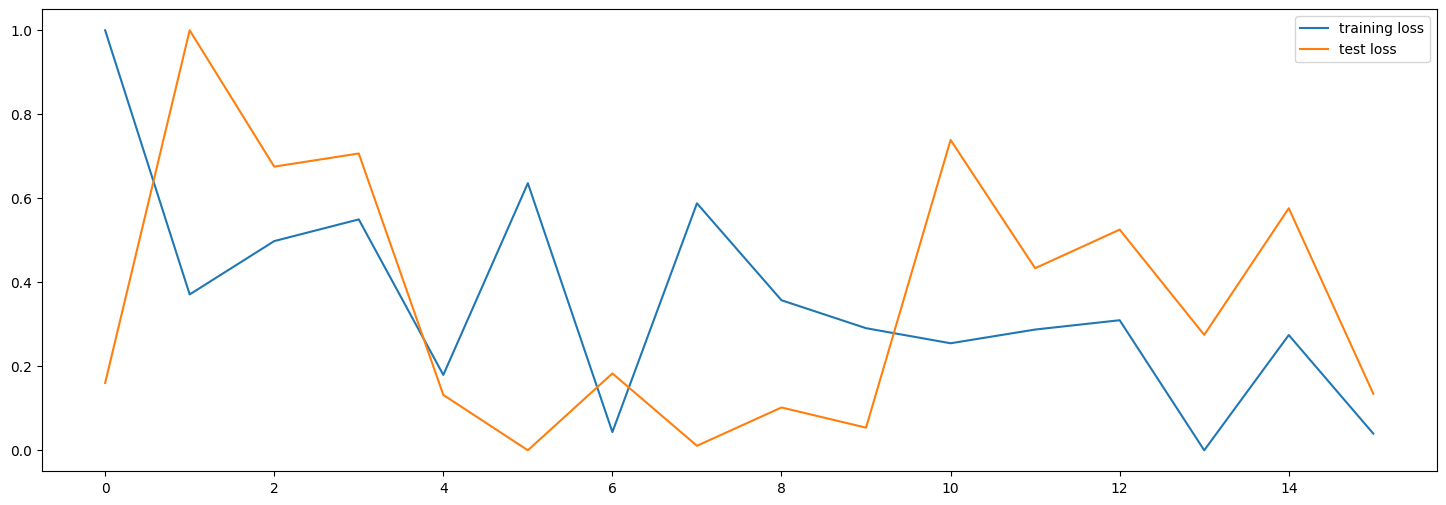

In [43]:
mse, hr_err, hr_err_sq = mod.eval()

print(f'\n\nMSE: {mse}')
print(f'HR error: {hr_err}')
print(f'HR error squared: {hr_err_sq}\n\n')

mod.get_model_stats()
mod.plot_loss()

True HR: 50.693069306930695; Pred HR: 70.58823529411765


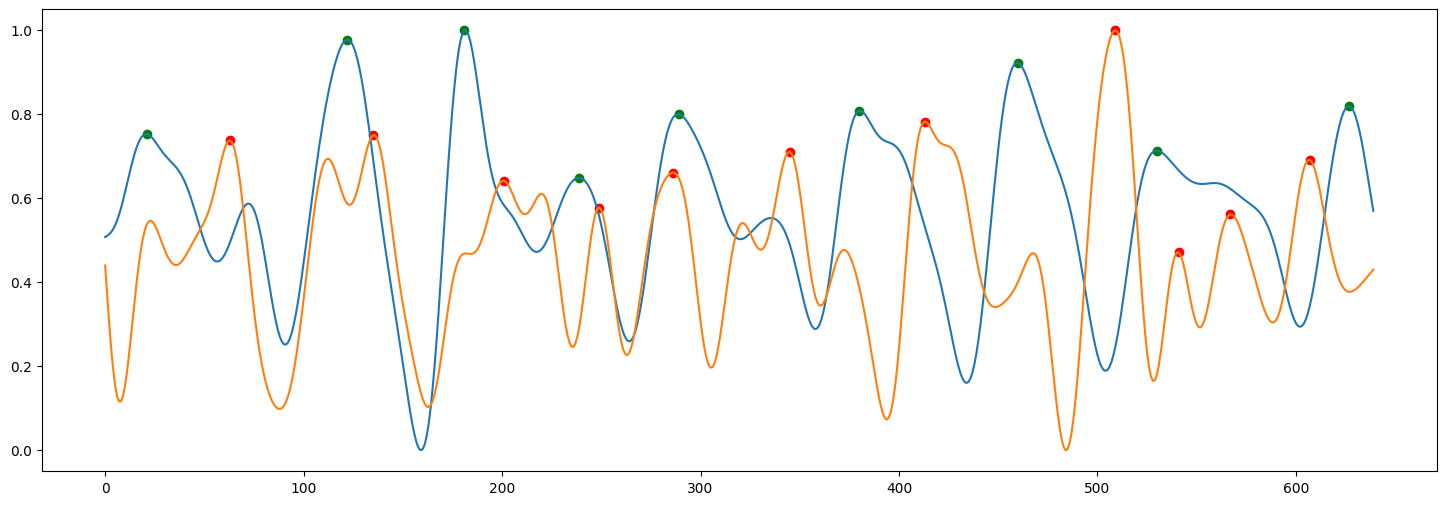

In [40]:
beg = 2000
end = beg + 640

model = mod

data = test_subject_truth.prepare_data_for_ml()
x = data.drop(columns = ['bvp']).to_numpy()
y = data['bvp'].to_numpy()

targ = y[beg: end]
pred = model.predict(x)[beg: end]
targ, pred = mod.process_signal(targ, pred, use_bandpass=True)

pred_peaks, _ = mod.get_predicted_peaks(pred)
true_peaks, _ = mod.get_true_peaks(targ)

plt.plot(targ)
plt.plot(pred)
plt.scatter(pred_peaks, pred[pred_peaks], c='r')
plt.scatter(true_peaks, targ[true_peaks], c='g')

pred_ibis = np.diff(pred_peaks) / 64
true_ibis = np.diff(true_peaks) / 64
pred_hr = get_hr(pred_ibis)
true_hr = get_hr(true_ibis)
print(f'True HR: {true_hr}; Pred HR: {pred_hr}')